In [5]:
import haccytrees.mergertrees
import h5py
import math
import numpy as np
import numpy.fft as fft 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [6]:
#%%time
use_SV = True
if use_SV:
    which_sim = "LJSV"
    forest, progenitor_array = haccytrees.mergertrees.read_forest('/data/a/cpac/mbuehlmann/LJSV/forest/m000p.forest.hdf5',
                                                                  'LastJourneySV', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11, include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z"])
# Leads to 23 rugs?
else:
    which_sim = "Last Journey"
    forest, progenitor_array = haccytrees.mergertrees.read_forest(
        "/data/a/cpac/mbuehlmann/LastJourney/forest/m000p.forest.000.hdf5", 'LastJourney', 
        nchunks=10, # or 1?
        chunknum=0, 
        mass_threshold=1e11
    )
# Leads to 15 rugs

In [7]:
thresholds = [5*10**11]
thresholds_are_absolute = True
norm = np.int(2.7*10**9)
xaxis = 'z_nums'
norm_tf = True
avg_tf = True
# Convert snapshots to redshifts -- opposite order (chronological)
redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))
N = 256
L = 250

# Fossil Groups Candidates

In [8]:
%%time
mlim = [1e13, 1e14]
xaxis = 'snap_nums'
absolute_threshold = True
threshold = 5e11
z_thresh = 1
norm_tf = False
restrict_mass = True
use_sigma = True
mrich_thresh = 0.1
# Go find yourself some fossil groups!
target_idx = help_func_haccytrees.find_halos(forest, mlim)
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold)
lmm_redshifts, lmm_index = help_func_haccytrees.get_lmms(major_mergers, threshold)
fgs, rugs, mrich = help_func_haccytrees.find_specials(forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx, z_thresh, mrich_thresh = mrich_thresh, restrict_mass = restrict_mass, use_sigma = use_sigma, mainbranch_masses = mainbranch_masses)
print(len(target_idx))
print(len(fgs))
print(len(rugs))
print(len(mrich))

finding merger rich halos, restricting mass with sigma
(6197,)
6197
382
23
362
CPU times: user 63.6 ms, sys: 35.8 ms, total: 99.4 ms
Wall time: 48.7 ms


# Get density field (from cosmic web map)

In [9]:
# Get delta
with h5py.File("/data/a/cpac/mbuehlmann/LJSV/maps/density.hdf5", "r") as f:
    delta = np.array(f['delta+1'], dtype=np.float64) - 1
    #rsoft = np.array(f['rsoft_0.0'], dtype=np.float64) # Well that sucks dude...
    print(f.keys()) # We've been using 'delta + 1', but we need something about density

<KeysViewHDF5 ['Tij', 'delta+1', 'eigvalsTij', 'rsoft_0.0', 'rsoft_1.0', 'rsoft_10.0', 'rsoft_2.0', 'rsoft_4.0', 'signatureTij']>


# Power Spectra, Auto/Cross-Correlation Functions

In [6]:
# Is this necessary?
import numpy as np
import numba

try:
    import pyfftw
except ImportError:
    print("pyfftw not available, using numpy fft")
    _fft = np.fft
    _has_pyfftw = False
    _fft_kwargs = {}
else:
    _fft = pyfftw.interfaces.numpy_fft
    _fft_kwargs = {'threads': 40}

def xi(delta_x, r, N, L): # x is a whole grid, so we just feed the whole function of x I guess? Do we even need the r?
    
    delta_k = fft.rfftn(delta_x)
    delta_k_conj = np.conjugate(delta_k)
    
    xi_r = fft.irfftn(delta_k * delta_k_conj)
    
    return xi_r

pyfftw not available, using numpy fft


## Spectra

6197
49115
[ 823.37101316  206.60498834   70.51698204 ...  596.62052071  298.64436793
 1201.58231433]
[ 822.37101316  205.60498834   69.51698204 ...  595.62052071  297.64436793
 1200.58231433]
49115
382
3056
[ 9279.4414548   6018.07515188  4725.84331287 ...  3042.91026779
 13384.0886873  10649.7680699 ]
[ 9278.4414548   6017.07515188  4724.84331287 ...  3041.91026779
 13383.0886873  10648.7680699 ]
3056
CPU times: user 6.96 s, sys: 1.15 s, total: 8.1 s
Wall time: 8.06 s


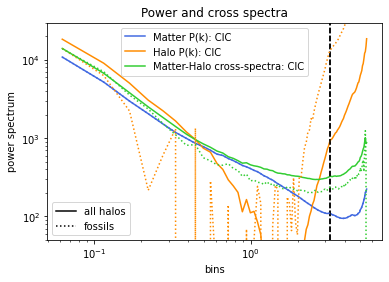

In [7]:
%%time
fig, ax = plt.subplots()

fake_lines = []
linestyles = iter(['-', ':'])
labels_list = ["all halos", "fossils"]
labels = iter(labels_list)
for i, halos in enumerate([target_idx, fgs]):
    current_linestyle = next(linestyles)
    current_label = next(labels)
    
    # Make sure you use positions, not coordinates!
    x_pos = forest['fof_halo_center_x'][halos]
    y_pos = forest['fof_halo_center_y'][halos]
    z_pos = forest['fof_halo_center_z'][halos]

    ax.axvline(np.pi*N/L, c = "black", linestyle = "--") # Nyquist frequency

    # Matter P(k)
    correct_CIC = True
    matter_pk = help_func_haccytrees.compute_pk_dens(delta, 100, L, correct_CIC) # nbins = 100
    matter_shot_noise = L**3/(1024**3)
    ax.plot(matter_pk[:, 0], matter_pk[:, 1] - matter_shot_noise, label = "Matter P(k): CIC", c = "royalblue", linestyle = current_linestyle)

    # Halo P(k)
    halo_shot_noise = L**3/len(halos)
    pos3d = np.array([x_pos, y_pos, z_pos]).T / L
    print(len(x_pos))
    pos3d = np.fmod(pos3d+1,1) # Deals with possible 'out of bounds' points
    resolution = N
    halo_rho = help_func_haccytrees.cic3d(pos3d, resolution)
    print(len(halo_rho[halo_rho > 0]))
    print(halo_rho[halo_rho > 0])
    delta_halos = halo_rho/np.average(halo_rho) - 1 # delta = overdensity
    print(delta_halos[delta_halos != -1])
    print(len(delta_halos[delta_halos != -1]))
    halo_pk = help_func_haccytrees.compute_pk_dens(delta_halos, 100, L, correct_CIC) # - halo_shot_noise # nbins = 100
    ax.plot(halo_pk[:, 0], halo_pk[:, 1] - halo_shot_noise, label = "Halo P(k): CIC", c = "darkorange", linestyle = current_linestyle)

    # Matter-Halo P(k)
    halo_matter_cross_pk = help_func_haccytrees.compute_pk_cross_dens(delta, delta_halos, 100, L, correct_CIC) # - halo_shot_noise # nbins = 100
    ax.plot(halo_matter_cross_pk[:, 0], halo_matter_cross_pk[:, 1], label = "Matter-Halo cross-spectra: CIC", c = "limegreen", linestyle = current_linestyle)

    # Cosmetics
    ax.set(xscale='log', yscale='log', xlabel = "bins", ylabel = "power spectrum", title = "Power and cross spectra") # Why is this giving `[None, None]` output?
    ax.set_ylim(bottom = 10**2 - 50, top = 3*10**4)
    if i == 0:
        handles, labels1 = ax.get_legend_handles_labels()
        legend1 = ax.legend(handles, labels1)
    fake_lines.append(ax.plot([],[], linestyle = current_linestyle, color="black", label = current_label))
    if i == 1:
        ax.legend([l[0] for l in fake_lines], labels_list, loc = "lower left") # do we need that "[0]"?
        ax.add_artist(legend1)

#fig.savefig("all_fgs_spectra_cic.png")

## Autocorrelation and Cross correlation from P(k)

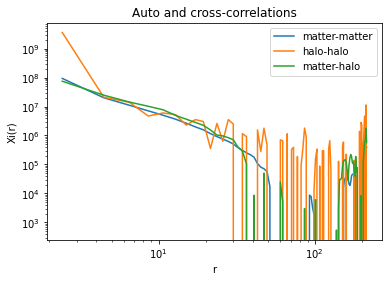

In [8]:
# Matter autocorrelation
fig, ax = plt.subplots()
labels = ["matter-matter", "halo-halo", "matter-halo"]
for i, this_delta in enumerate([delta, delta_halos]):
    xi_r = help_func_haccytrees.compute_autocorr(this_delta)
    ax.plot(xi_r[:,0], xi_r[:,1], label = labels[i])
    
# Now add the cross-correlation
cross_xi_r = help_func_haccytrees.compute_crosscorr(delta, delta_halos)# what should this actually be called?
ax.plot(cross_xi_r[:,0], cross_xi_r[:,1], label = labels[-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("r")
ax.set_ylabel("Xi(r)")
ax.set_title("Auto and cross-correlations")
ax.legend()
#fig.savefig("correlations.png")

### Why isn't this working?

[None, None, Text(0.5, 0, 'k'), Text(0, 0.5, '$P_{hh} / P_{mm}$')]

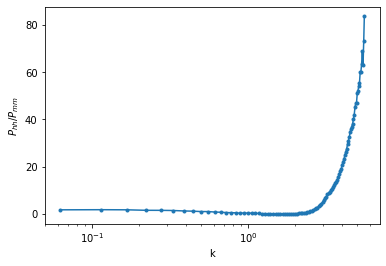

In [9]:
# P_halo / P_matter vs. k bins
halos = target_idx #fgs
x_pos = forest['fof_halo_center_x'][halos] # Make sure you use positions, not coordinates!
y_pos = forest['fof_halo_center_y'][halos]
z_pos = forest['fof_halo_center_z'][halos]

# Halo P(k)
pos3d = np.array([x_pos, y_pos, z_pos]).T / L
pos3d = np.fmod(pos3d+1,1) # Deals with possible 'out of bounds' points
resolution = N
halo_rho = help_func_haccytrees.cic3d(pos3d, resolution)
delta_halos = halo_rho/np.average(halo_rho) - 1 # delta = overdensity
halo_pk = help_func_haccytrees.compute_pk_dens(delta_halos, 100, L, correct_CIC) # - halo_shot_noise # nbins = 100
halo_shot_noise = L**3/len(halos)

# Matter P(k)
correct_CIC = True
matter_pk = help_func_haccytrees.compute_pk_dens(delta, 100, L, correct_CIC) # nbins = 100
matter_shot_noise = L**3/(1024**3)

# Plot the ratio P_halo / P_matter
fig, ax = plt.subplots()
ratio = (halo_pk[:, 1] - halo_shot_noise) / (matter_pk[:, 1] - matter_shot_noise)
ax.plot(matter_pk[:, 0], ratio, marker = '.')
ax.set(xscale='log', yscale='linear', xlabel = "k", ylabel=r'$P_{hh} / P_{mm}$')
#fig.savefig("matter_vs_halo_pk.png")

# Compare to Adrian's approach

### Save what I have

In [40]:
halo_rhos = []
halo_positions = []
for halos in [target_idx, fgs]:
    # Make sure you use positions, not coordinates!
    x_pos = forest['fof_halo_center_x'][halos]
    y_pos = forest['fof_halo_center_y'][halos]
    z_pos = forest['fof_halo_center_z'][halos]
    halo_positions.append(np.concatenate(([x_pos], [y_pos], [z_pos]), axis = 0).T)

    pos3d = np.array([x_pos, y_pos, z_pos]).T / L
    pos3d = np.fmod(pos3d+1,1) # Deals with possible 'out of bounds' points
    resolution = N
    halo_rhos.append(help_func_haccytrees.cic3d(pos3d, resolution))

#print(halo_positions)
delta_halos = halo_rhos[0]/np.average(halo_rhos[0]) - 1
fg_delta_halos = halo_rhos[1]/np.average(halo_rhos[1]) - 1 # delta = overdensity
#print(type(fg_delta_halos))

make_dataset = True
if make_dataset:
    f = h5py.File('density_fields.h5', 'w') # 'w' = write
    f.attrs.create("n_halos", len(target_idx))
    f.attrs.create("n_fgs", len(fgs))
    f.attrs.create("n_particles", 1024**3) # You will have to change this one by hand
    f.create_dataset('halo_positions', data = halo_positions[0])
    f.create_dataset('fg_positions', data = halo_positions[1])
    f.create_dataset('halo_overdensity', data = delta_halos)
    f.create_dataset('fgs_halo_overdensity', data = fg_delta_halos) # Change this name later (but not now, because collaborating)
    f.create_dataset('matter_overdensity', data = delta)
    f.close()

In [45]:
# Open it again (to take a look!)
with h5py.File('density_fields.h5', 'r') as hf: # 'r' = read
    print(hf.keys())
    print(hf.attrs.keys())
    n_halos = hf.attrs['n_halos']
    halo_positions = hf['halo_positions'][:]
    fg_positions = hf['fg_positions'][:]
    all_halos = hf['halo_overdensity'][:]
    fg_halos = hf['fgs_halo_overdensity'][:]
    matter = hf ['matter_overdensity'][:]

<KeysViewHDF5 ['fg_positions', 'fgs_halo_overdensity', 'halo_overdensity', 'halo_positions', 'matter_overdensity']>
<KeysViewHDF5 ['n_fgs', 'n_halos', 'n_particles']>


In [56]:
print(len(all_halos[all_halos != -1]))
print(fg_halos[fg_halos != -1])

49115
[ 9278.4414548   6017.07515188  4724.84331287 ...  3041.91026779
 13383.0886873  10648.7680699 ]


In [37]:
len(fg_halos[fg_halos < 0])

16774162

### Do Michael's parallelized spectra/correlation codes give the same results?

% Run this in a terminal in case you ever want to run Michael's parallelized codes
% Won't work in python environment ;P
FILE=/data/a/cpac/aurora/fossil_groups/density_fields.h5
KEY_MATTER=matter_overdensity
KEY_HALO=halo_overdensity
PROCS=4
mpirun -n $PROCS python executables/parallel_2pt_stats.py \
    --delta1-file $FILE \
    --delta1-key $KEY_MATTER \
    --delta1-deconvolve-CIC \
    --delta2-file $FILE \
    --delta2-key $KEY_HALO \
    --delta2-deconvolve-CIC \
    --box-size 250 \
    --nbins 100 \
    --rspace \
    --output-file matter_halo.corr.tx

In [4]:
corr_path = "/data/a/cpac/mbuehlmann/LJSV/correlations"

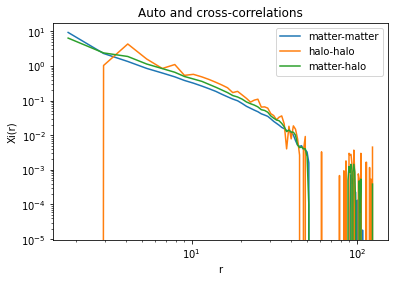

In [8]:
# Matter autocorrelation
fig, ax = plt.subplots()

# Matter autocorrelation
matter_corr = np.loadtxt(f"{corr_path}/matter_matter.corr.txt")
ax.plot(matter_corr[:,0], matter_corr[:,1], label = "matter-matter")

# Halo autocorrelation
halo_corr = np.loadtxt(f"{corr_path}/halo_halo.corr.txt")
ax.plot(halo_corr[:,0], halo_corr[:,1], label = "halo-halo")

# Cross correlation
matter_halo_corr = np.loadtxt(f"{corr_path}/matter_halo.corr.txt")
ax.plot(matter_halo_corr[:,0], matter_halo_corr[:,1], label = "matter-halo")

# Cosmetics
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("r")
ax.set_ylabel("Xi(r)")
ax.set_title("Auto and cross-correlations")
ax.legend()
fig.savefig("Michaels_correlations.png")

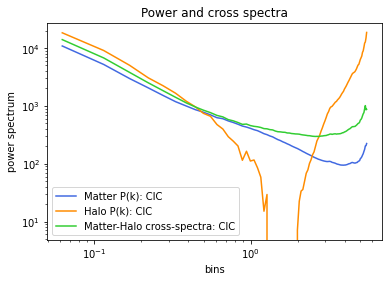

In [12]:
# Plot them -- I assume this is for all halos, not specifically fgs?
fig, ax = plt.subplots()

# Matter P(k)
matter_pk = np.loadtxt(f"{corr_path}/matter_matter.pk.txt")
matter_shot_noise = L**3/(1024**3)
ax.plot(matter_pk[:, 0], matter_pk[:, 1] - matter_shot_noise, label = "Matter P(k): CIC", c = "royalblue")

# Halo P(k)
halos = target_idx
halo_shot_noise = L**3/len(halos)
halo_pk = np.loadtxt(f"{corr_path}/halo_halo.pk.txt")
ax.plot(halo_pk[:, 0], halo_pk[:, 1] - halo_shot_noise, label = "Halo P(k): CIC", c = "darkorange")
#ax.plot(halo_pk[:, 0], halo_pk[:, 1], label = "Halo P(k): CIC", c = "darkorange")

# Matter-Halo P(k)
matter_halo_pk = np.loadtxt(f"{corr_path}/matter_halo.pk.txt")
ax.plot(matter_halo_pk[:, 0], matter_halo_pk[:, 1], label = "Matter-Halo cross-spectra: CIC", c = "limegreen")

# Cosmetics
ax.set(xscale='log', yscale='log', xlabel = "bins", ylabel = "power spectrum", title = "Power and cross spectra") # Why is this giving `[None, None]` output?
ax.legend()
#ax.set_ylim(bottom = 10**2 - 50, top = 3*10**4)

#fig.savefig("Michaels_spectra.png")

## Old Random Attempts

In [ ]:
# From me
ps = np.zeros((x,y,z), dtype=np.float64)
x_coords_all = forest['fof_halo_center_x'][all_halos]*N/L # that *N/L is very important!
y_coords_all = forest['fof_halo_center_y'][all_halos]*N/L
z_coords_all = forest['fof_halo_center_z'][all_halos]*N/L

use_ngm = True
if use_ngm:
    x[x_coords_all.astype(int)] += 1

#kgrid = np.meshgrid(kx, ky, kz, indexing='ij')
#kgrid: first 3 are x, y, and z axis, then the next dimensions are the grids for x y and z
kxgrid, kygrid, kzgrid = np.meshgrid(kx, ky, kz, indexing='ij')
k_squared = kxgrid**2 + kygrid**2 + kzgrid**2
k_squared[0,0,0] = 1

In [ ]:
# Matter P(k) for halos
# Do we want these smoothed?
sigma = 2 # Mpc/h
delta_smooth = help_func_haccytrees.smooth_f(delta, sigma)
# make a mask for delta that only includes halo centers?
fg_deltas = (delta_smooth + 1)[x_coords_fg.astype(int), y_coords_fg.astype(int), z_coords_fg.astype(int)]
all_halos_deltas = (delta_smooth + 1)[x_coords_all.astype(int), y_coords_all.astype(int), z_coords_all.astype(int)]
pk_all = compute_pk_dens(all_halos_deltas, 100, L) # nbins = 100
pk_fgs = compute_pk_dens(fg_deltas, 100, L)